In [1]:
import deepqmc
import haiku as hk
import jax

In [2]:
from deepqmc.molecule import Molecule

mol = Molecule(  # LiH
    coords=[[0.0, 0.0, 0.0], [3.015, 0.0, 0.0]],
    charges=[3, 1],
    charge=0,
    spin=0,
    unit='bohr',
)

In [3]:
from deepqmc.hamil import MolecularHamiltonian

H = MolecularHamiltonian(mol=mol)

In [4]:
import os

import haiku as hk
from hydra import compose, initialize_config_dir
from hydra.utils import instantiate

import deepqmc
from deepqmc.app import instantiate_ansatz


deepqmc_dir = os.path.dirname(deepqmc.__file__)
config_dir = os.path.join(deepqmc_dir, 'conf/ansatz')

with initialize_config_dir(version_base=None, config_dir=config_dir):
    cfg = compose(config_name='psiformer')

_ansatz = instantiate(cfg, _recursive_=True, _convert_='all')

psiformer_ansatz = instantiate_ansatz(H, _ansatz)

In [ ]:

mol = Molecule(  # LiH
    coords=[[0.0, 0.0, 0.0], [3.015, 0.0, 0.0]],
    charges=[3, 1],
    charge=0,
    spin=0,
    unit='bohr',
)

In [5]:
from deepqmc.wf.nn_wave_function import eval_log_slater, Psi
from deepqmc.wf.env import ExponentialEnvelopes
from deepqmc.physics import pairwise_diffs
from deepqmc.app import instantiate_ansatz
from deepqmc.types import PhysicalConfiguration
import jax.numpy as jnp

class MyWF(hk.Module):
    def __init__(
        self,
        hamil,
    ):
        super().__init__()
        self.mol = hamil.mol
        self.n_up, self.n_down = hamil.n_up, hamil.n_down
        self.charges = hamil.mol.charges
        self.env = ExponentialEnvelopes(hamil,1,isotropic=False, per_shell=False, per_orbital_exponent=False, spin_restricted=False, init_to_ones=False, softplus_zeta=False)

    @property
    def spin_slices(self):
        return slice(None, self.n_up), slice(self.n_up, None)

    def __call__(self, phys_conf:PhysicalConfiguration, _):
        n_elec = self.n_up + self.n_down
        orb = self.env(phys_conf, None)
        elec_nuc_diffs = pairwise_diffs(phys_conf.r, phys_conf.R).reshape(n_elec, -1)
        elec_emebeddings = jnp.concatenate((elec_nuc_diffs, jnp.concatenate((jnp.ones(self.n_up), -jnp.ones(self.n_down)))[...,None]),axis=-1) 
        # TRANSFORMER BLOCK
        f = hk.Linear(self.n_up+self.n_down)(elec_emebeddings)
        orb *= f[None]
        sign_psi, log_psi = eval_log_slater(orb)
        sign_psi = jax.lax.stop_gradient(sign_psi)
        return Psi(sign_psi.squeeze(), log_psi.squeeze())


In [ ]:

mol = Molecule(  # LiH
    coords=[[0.0, 0.0, 0.0], [3.015, 0.0, 0.0]],
    charges=[3, 1],
    charge=0,
    spin=0,
    unit='bohr',
)

In [ ]:

mol = Molecule(  # LiH
    coords=[[0.0, 0.0, 0.0], [3.015, 0.0, 0.0]],
    charges=[3, 1],
    charge=0,
    spin=0,
    unit='bohr',
)

In [6]:
my_ansatz = instantiate_ansatz(H, MyWF)

In [7]:
from deepqmc.sampling import initialize_sampling, MetropolisSampler, DecorrSampler, combine_samplers
from functools import partial

elec_sampler = partial(combine_samplers, samplers=[DecorrSampler(length=20), partial(MetropolisSampler)])
sampler_factory = partial(initialize_sampling, elec_sampler=elec_sampler)

In [8]:
import os

from hydra import compose, initialize_config_dir
from hydra.utils import instantiate

deepqmc_dir = os.path.dirname(deepqmc.__file__)
config_dir = os.path.join(deepqmc_dir, 'conf/task/opt')

with initialize_config_dir(version_base=None, config_dir=config_dir):
    cfg = compose(config_name='kfac')

kfac = instantiate(cfg, _recursive_=True, _convert_='all')

In [9]:
from deepqmc.train import train
train(H, psiformer_ansatz, kfac, sampler_factory, steps=1000, electron_batch_size=2000, seed=42, workdir='baseline_psiformer')

equilibrate sampler:   0%|          | 0/1000 [00:00<?, ?it/s]

training:   0%|          | 0/1000 [00:00<?, ?it/s]

TrainState(sampler={'elec': {'age': Array([[[[1, 0, 0, ..., 1, 2, 5]]]], dtype=int32), 'psi': Psi(sign=Array([[[[-1.,  1.,  1., ...,  1., -1.,  1.]]]], dtype=float32), log=Array([[[[7.0495224, 4.050668 , 5.4885364, ..., 2.7581682, 6.748012 ,
          6.3701677]]]], dtype=float32)), 'r': Array([[[[[[ 7.4998096e-02, -2.6347890e-02,  2.2104909e-01],
           [ 4.2036061e+00, -7.1210635e-01,  3.5475311e-01],
           [ 1.0580235e+00,  4.9254632e-01,  2.5057805e+00],
           [ 1.9289821e-02, -2.2503489e-01, -5.1893193e-02]],

          [[ 3.9669917e+00,  9.5127439e-01, -1.8344319e-01],
           [ 8.5456908e-02, -6.2997085e-01, -2.5893924e-01],
           [ 3.3839676e+00, -1.1080984e+00,  3.5556006e+00],
           [ 5.2497017e-01,  4.1007936e-01, -6.5741509e-02]],

          [[ 1.6028833e-01, -2.8671783e-01, -2.9300985e-01],
           [ 3.9970291e+00,  2.0431509e+00,  1.4514382e+00],
           [ 4.7456750e-01,  2.7085716e-01,  7.3931080e-01],
           [ 2.3428745e+00,  1.86525

In [ ]:
import os

from hydra import compose, initialize_config_dir
from hydra.utils import instantiate

deepqmc_dir = os.path.dirname(deepqmc.__file__)
config_dir = os.path.join(deepqmc_dir, 'conf/task/opt')

with initialize_config_dir(version_base=None, config_dir=config_dir):
    cfg = compose(config_name='kfac')

kfac = instantiate(cfg, _recursive_=True, _convert_='all')

In [10]:
import h5py
with h5py.File('tmp/training/result.h5', 'r', swmr=True) as f:
    energy = f['local_energy']['mean'][:]

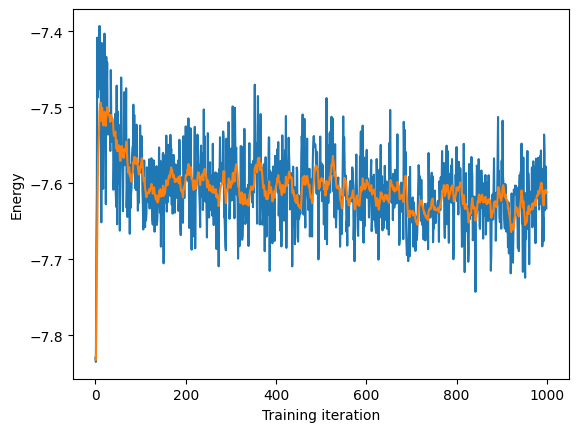

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(energy[:,0,0])
plt.plot(pd.DataFrame(energy[:,0,0]).ewm(halflife=5).mean())
plt.xlabel('Training iteration')
plt.ylabel('Energy')
plt.show()